In [17]:
import pandas as pd
import numpy as np
import glob
import os
import re
import string
from textblob import TextBlob
import preprocessor as p
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [18]:
# read all files 
files = sorted(glob.glob("../data/raw_baseline/*_articles.csv"))

file_names = []

for file_path in files:
    file_name = re.split("_", os.path.basename(file_path))[1].split('.')[0]
    
    hd = pd.read_csv(file_path)
    file_names.append(hd)
    

df = pd.concat(file_names).reset_index().drop(["Unnamed: 0", "index"], axis=1)

In [19]:
# read metadata file
newsrooms = pd.read_csv('../data/raw/newsrooms.csv')
newsrooms.columns = ['site', 'monthly_visits', 'country', 'country_of_pub']
newsrooms.dropna(inplace=True)
newsrooms = newsrooms.drop_duplicates(subset = 'site')
newsrooms = newsrooms.sort_values(by=['country_of_pub', 'monthly_visits'], ascending=False).reset_index().drop('index', axis=1)

In [20]:
df['site'] = df['site'].str.replace("https://www.",'')
df['site'] = df['site'].str.replace("https://",'')

In [21]:
df = df[['url', 'headline', 'time', 'scrape_date', 'site']]

In [22]:
df = pd.merge(newsrooms, df, on = 'site')

In [23]:
print("This dataset has", len(df[df['country_of_pub']=='South Africa']), "headlines from South Africa", len(df[df['country_of_pub']=='India']), "headlines from India",
      len(df[df['country_of_pub']=='UK']), "headlines from the UK and", len(df[df['country_of_pub']=='USA']), "headlines from the U.S.")

This dataset has 28592 headlines from South Africa 105944 headlines from India 118517 headlines from the UK and 163560 headlines from the U.S.


In [24]:
print("This dataset covers", len(df.site[df['country_of_pub']=='South Africa'].unique()), "news outlets from South Africa", len(df.site[df['country_of_pub']=='India'].unique()), 
      "news outlets from India", len(df.site[df['country_of_pub']=='UK'].unique()), "news outlets from the UK and", len(df.site[df['country_of_pub']=='USA'].unique()), "news outlets from the U.S.")

This dataset covers 24 news outlets from South Africa 36 news outlets from India 43 news outlets from the UK and 89 news outlets from the U.S.


In [25]:
df.shape

(416613, 8)

In [26]:
# from https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
from pycontractions import Contractions
import gensim.downloader as api
import en_core_web_lg

#nlp = spacy.load('en_core_web_lg')
nlp = en_core_web_lg.load()



# exclude words from spacy stopwords list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False


def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text


def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


# def expand_contractions(text):
#     """expand shortened words, e.g. don't to do not"""
#     text = list(cont.expand_texts([text], precise=True))[0]
#     return text


def text_preprocessing(text, accented_chars=True, contractions=False, 
                       convert_num=True, extra_whitespace=True, 
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=True, remove_num=True, special_chars=True, 
                       stop_words=True):
    """preprocess text with default option set to true for all steps"""
    if remove_html == True: #remove html tags
        text = strip_html_tags(text)
    if extra_whitespace == True: #remove extra whitespaces
        text = remove_whitespace(text)
    if accented_chars == True: #remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: #expand contractions
        text = expand_contractions(text)
    if lowercase == True: #convert all characters to lowercase
        text = text.lower()

    doc = nlp(text) #tokenise text

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # remove punctuations
        if punctuations == True and token.pos_ == 'PUNCT' and flag == True: 
            flag = False
        # remove special characters
        if special_chars == True and token.pos_ == 'SYM' and flag == True: 
            flag = False
        # remove numbers
        if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
        # convert number words to numeric numbers
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)        
    return clean_text

In [36]:
%%time
import re

df['headline_no_site'] = df['headline'].str.split("- ").str[0]
df['headline_no_site'] = df['headline_no_site'].apply(lambda x: re.sub(r'[^\w\s]', '',x))
#df['headline_no_site'] = df['headline_no_site'].apply(lambda x: x.replace('"', "").replace(")", "").replace("]", "").replace(",", "").replace("'", "").replace(":", "")
#df['headline_no_site'] = df['headline_no_site'].apply(lambda x: ''.join(re.split("(?<=[a-z0-9.!’?!\\-…”*�%'`A-Z])[A-Z]", x)[:-1]))
df['clean_headline'] = df['headline_no_site'].apply(text_preprocessing)
#df['subtitle'][df['subtitle'].isna() == True] = ""
#df['clean_subtitle'] = df['subtitle'].apply(text_preprocessing)

Wall time: 1h 6min 47s


In [37]:
df['clean_headline']

0         [espn, college, football, celebrate, largertha...
1                                                   [agent]
2                                          [bull, vs, hawk]
3                                       [super, bowl, liii]
4            [dirk, pass, wilt, nbas, 6th, alltime, scorer]
                                ...                        
416608    [bank, offer, credit, card, defaulter, easy, l...
416609    [union, budget, fm, slap, excise, duty, litre,...
416610            [supreme, court, talk, tough, land, grab]
416611           [ashok, leyland, roll, salary, cut, board]
416612         [singapore, olam, offer, r, lakh, pay, iiml]
Name: clean_headline, Length: 416613, dtype: object

In [35]:
df['headline_no_site'][df['headline_no_site'].str.contains(']')]

Series([], Name: headline_no_site, dtype: object)

In [38]:
df.shape

(416613, 10)

In [39]:
def remove_women(words, stopwords):
    for word in list(words):  # iterating on a copy since removing will mess things up
        if word in stopwords:
            words.remove(word)
    return words

In [40]:
import ast
women_words = ['women', 'woman', 'girl', 'girls', 'female', 'females', 'lady', 'ladies', 'she', 'her']
df['clean_hl_words'] = df['clean_headline'] #.apply(lambda row: ast.literal_eval(row))
df['clean_hl_words_no_women'] = df['clean_hl_words'].apply(lambda row: remove_women(row, women_words))

In [41]:
df.shape

(416613, 12)

In [42]:
df.to_csv('../data/processed/headlines_cl_base.csv')

In [44]:
df_cl = pd.read_csv('../data/processed/headlines_cl_base.csv')

### Sentiment Analysis

In [45]:
# drop NAs for sentiment analyzer
df_cl = df_cl[df_cl['headline_no_site'].isna()==False].reset_index()

In [46]:
df_cl.shape

(416610, 14)

In [47]:
%%time
column = "headline_no_site"
#importing and initialising the VADER analyser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#Storing the scores in list of dictionaries
scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(df_cl['headline_no_site'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['Tweet'][i]))
    compound = analyzer.polarity_scores(df_cl[column][i])["compound"]
    pos = analyzer.polarity_scores(df_cl[column][i])["pos"]
    neu = analyzer.polarity_scores(df_cl[column][i])["neu"]
    neg = analyzer.polarity_scores(df_cl[column][i])["neg"]
    
    scores.append({"compound_s": compound,
                       "positive_s": pos,
                       "negative_s": neg,
                       "neutral_s": neu
                  })

#Appending the scores into the dataframe for further analysis 
sentiments_score = pd.DataFrame.from_dict(scores)
df_cl_sent = df_cl.join(sentiments_score)

Wall time: 2min 15s


Text(0.5, 0, 'Compound Sentiment')

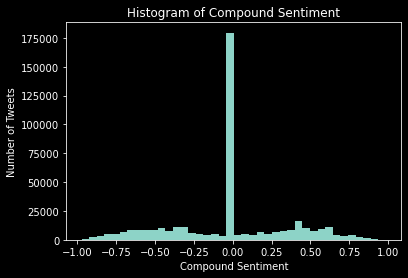

In [49]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.hist(df_cl_sent['compound_s'].values, bins=40)
plt.title('Histogram of Compound Sentiment')
plt.ylabel('Number of Tweets')
plt.xlabel('Compound Sentiment')

In [50]:
df_cl_sent['country_of_pub'].unique()

array(['USA', 'UK', 'South Africa', 'India'], dtype=object)

In [51]:
df_cl_sent.drop(['index', 'Unnamed: 0'], axis=1).to_csv('../data/processed/headlines_cl_sent_base.csv')

In [131]:
df_cl_sent = pd.read_csv('../data/processed/headlines_cl_sent_base.csv')

In [126]:
#df_cl_sent.drop(columns=['url', 'time', 'scrape_date', 'clean_hl_words', 'clean_hl_words_no_women']).to_csv('../hosted_data/headlines_cl_sent_base_pol.csv')

In [129]:
#df_cl_sent = pd.read_csv('../hosted_data/headlines_cl_sent_base_pol.csv')

### Word Frequencies

In [132]:
#total word frequency
import ast
df_cl_sent['clean_hl_words'] = df_cl_sent['clean_hl_words'].apply(lambda row: ast.literal_eval(row))
df_cl_sent['clean_headline_str'] = df_cl_sent['clean_hl_words'].apply(lambda x: ' '.join(x))
df_cl_sent['clean_headline_str'] =  df_cl_sent['clean_headline_str'].str.replace('[^\w\s]','')
df_cl_sent['clean_headline_str'] = df_cl_sent['clean_headline_str'].apply(lambda row: ' '.join( [w for w in row.split() if len(w)>1] ))
df_cl_sent['clean_hl_words'] = df_cl_sent['clean_headline_str'].apply(lambda x: list(x.split(" ")))
word_freq = pd.DataFrame(df_cl_sent.clean_headline_str.str.split(expand=True).stack().value_counts()).reset_index()
word_freq.columns = ['word','frequency']

In [133]:
word_freq.to_csv('../data/processed/words_freq_base.csv')

In [291]:
# SA_freq = pd.DataFrame(df_cl_sent.clean_headline_str[df_cl_sent["country_of_pub"] == 'South Africa'].str.split(expand=True).stack().value_counts()).reset_index()
# SA_freq.columns = ['word','frequency']

In [134]:
# word frequency by country
dfs = []

for country in df_cl_sent.country_of_pub.unique():
    country_freq = pd.DataFrame(df_cl_sent.clean_headline_str[df_cl_sent["country_of_pub"] == country].str.split(expand=True).stack().value_counts()).reset_index()
    country_freq.columns = ['word','frequency']
    country_freq['country'] = country
    dfs.append(country_freq)
    
countries_freq = pd.concat(dfs)

In [136]:
# word frequency by publication
dfs = []

for site in df_cl_sent[df_cl_sent["site"] != 'drudgereport.com'].site.unique():
    site_freq = pd.DataFrame(df_cl_sent[df_cl_sent["site"] != 'drudgereport.com'].clean_headline_str[df_cl_sent["site"] == site].str.split(expand=True).stack().value_counts()).reset_index()
    site_freq.columns = ['word','frequency']
    site_freq['site'] = site
    dfs.append(site_freq)
    
sites_freq = pd.concat(dfs)

In [137]:
countries_freq.to_csv('../data/processed/countries_freq_base.csv')
sites_freq.to_csv('../data/processed/sites_freq_base.csv')

In [141]:
df_cl_sent['compound_s']

0       0.3182
1       0.0000
2       0.4588
3       0.0000
4       0.0000
         ...  
3182    0.0000
3183    0.0516
3184    0.0000
3185    0.0000
3186    0.0000
Name: compound_s, Length: 3187, dtype: float64

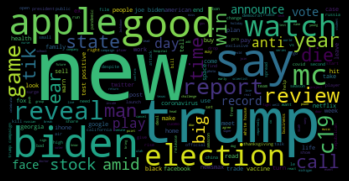

In [139]:
from wordcloud import WordCloud, STOPWORDS
text = df_cl_sent['clean_headline_str'].tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()
#text
#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True).generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

### Todo
- add more words to stopwords
- translate time and make time stamps for each one - Sahiti
- word frequencies by publication and country - Leo/done
- sentiment by publication and country over time
- Topic modelling
- topics by publication and country over time